Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 0.1081 - loss: 2.3847 - val_accuracy: 0.4759 - val_loss: 1.8718
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.1602 - loss: 2.1250 - val_accuracy: 0.4808 - val_loss: 1.8837
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.2205 - loss: 2.0150 - val_accuracy: 0.3635 - val_loss: 1.9004
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - accuracy: 0.3077 - loss: 1.9376 - val_accuracy: 0.3635 - val_loss: 1.9481
pérdida de prueba: 1.8718
precisión de la prueba: 0.4759
Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.1675 - loss: 2.1148 - val_accuracy: 0.4763 - val_loss: 1.8788
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.2443 - loss: 1.9965 - val_accuracy: 0.3635 - val_loss: 1.8989
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.3107 - loss: 1.9347 - val_accuracy: 0.3635 - val_loss: 1.9393
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms

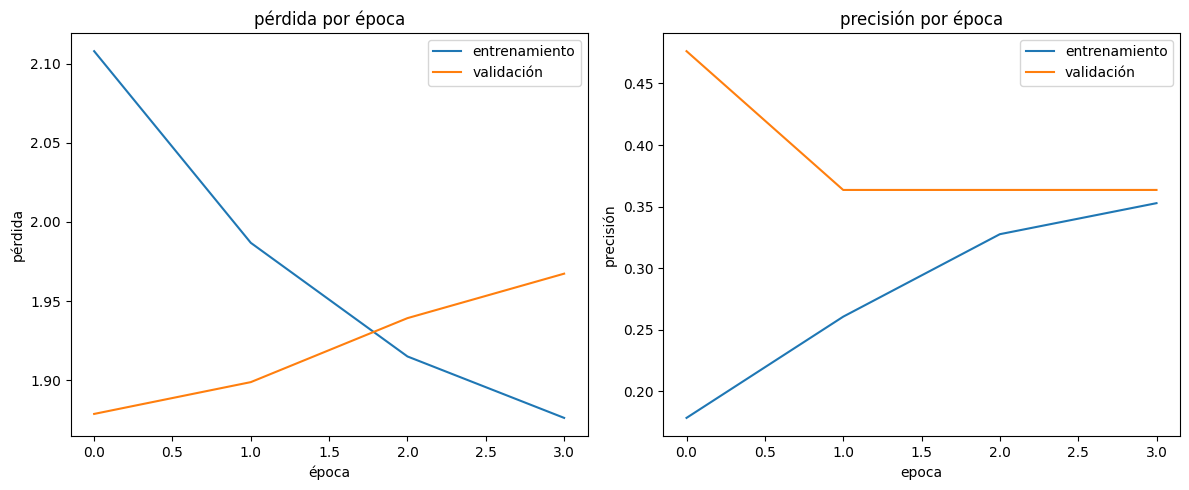

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

data = pd.read_csv('covidata.csv')
data.replace([97, 98, 99, '9999-99-99'], np.nan, inplace=True)
data.fillna(data.mode().iloc[0], inplace=True)
data.drop(['USMER', 'MEDICAL_UNIT', 'DATE_DIED'], axis=1, inplace=True)
data = pd.get_dummies(data, columns=['SEX', 'PATIENT_TYPE'], drop_first=True)

data = pd.read_csv('covidata.csv')
data.replace([97, 98, 99, '9999-99-99'], np.nan, inplace=True)
data.fillna(data.mode().iloc[0], inplace=True)
data.drop(['USMER', 'MEDICAL_UNIT', 'DATE_DIED'], axis=1, inplace=True)
data = pd.get_dummies(data, columns=['SEX', 'PATIENT_TYPE'], drop_first=True)

#variables
X = data.drop(['CLASIFFICATION_FINAL'], axis=1)
y = data['CLASIFFICATION_FINAL'] - data['CLASIFFICATION_FINAL'].min()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=y.nunique())
y_test = tf.keras.utils.to_categorical(y_test, num_classes=y.nunique())

#tamaño para pruebas
X_train_small = X_train[:5000]
y_train_small = y_train[:5000]

#modelo LSTM
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(16, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(8),
    BatchNormalization(),
    Dropout(0.2),
    Dense(y.nunique(), activation='softmax')
])

#compilacion y entrenamiento con early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_small, y_train_small, epochs=30, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'pérdida de prueba: {loss:.4f}')
print(f'precisión de la prueba: {accuracy:.4f}')

import matplotlib.pyplot as plt
history = model.fit(
    X_train_small, y_train_small,
    epochs=30,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

#perdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='entrenamiento')
plt.plot(history.history['val_loss'], label='validación')
plt.title('pérdida por época')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.legend()

#precision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='entrenamiento')
plt.plot(history.history['val_accuracy'], label='validación')
plt.title('precisión por época')
plt.xlabel('epoca')
plt.ylabel('precisión')
plt.legend()

plt.tight_layout()
plt.show()


# Enfoque

El modelo se basó en la clasificación de casos COVID-19. La estructura del modelo es una red LSTM bidimensional, con dos capas LSTM de 128 y 64 unidades. Dentro de este, mediante la moda, reemplacé valores vacíos con valores estimados. Omití columnas innecesarias y transformé las variables categóricas en representaciones numéricas mediante one-hot. Los datos de entrada los escalé con MinMaxScaler para dar estabilidad y eficiencia al entrenamiento. Incorporé Batch Normalization para estabilizar el modelo y Dropout para disminuir el sobreajuste. Y para la capa de salida usé softmax para la clasificación multiclase.
Usé la función de perdida categorial_crossentropy y el optimizador Adam con una tasa de aprendizaje 0.0005. El modelo se entrena por 100 épocas con un tamaño de “lote” de 64 y por última se evalúa empleando precisión en el conjunto de prueba.